## Image Classification Using CNN - Fashion MNIST

**Dataset chosen: Fashion MNIST**

This dataset has 60000 training set images and 10000 test set images. This images are clothing images, and the purpose of the dataset is to classify the images into ten classes. These classes are:

* 0 -> 0 T-shirt/top
* 1 -> Trouser
* 2 -> Pullover
* 3 -> Dress
* 4 -> Coat
* 5 -> Sandal
* 6 -> Shirt
* 7 -> Sneaker
* 8 -> Bag
* 9 -> Ankle boot 

Importing required libaries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import backend as K
import os
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import InputLayer, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from skopt import gp_minimize, dump, load
from skopt.space import Real, Integer
from skopt.plots import plot_convergence
from skopt.utils import use_named_args

Using TensorFlow backend.


Checking versions of Keras and Tensorflow:

In [2]:
#Keras version:
keras.__version__

'2.1.6'

In [3]:
#Tensorflow version:
tf.__version__

'1.10.0'

Importing the Fashion MNIST data from keras.datasets:

In [4]:
#X_train -> predictor variables for training set
#X_test -> predictor variables for test set
#y_train -> responses for training set
#y_test -> predictions for test set

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

The **data types** of X_train, X_test, y_train and y_test are:

In [5]:
print('Data type of X_train: ' , type(X_train))
print('Data type of y_train: ' , type(y_train))
print('Data type of X_test: ' , type(X_test))
print('Data type of y_test: ' , type(y_test))

Data type of X_train:  <class 'numpy.ndarray'>
Data type of y_train:  <class 'numpy.ndarray'>
Data type of X_test:  <class 'numpy.ndarray'>
Data type of y_test:  <class 'numpy.ndarray'>


It can be seen that the training and testing response and predictor variables are numpy arrays.

The **dimensions of the images (in pixels)** in the training and testing set are:

In [6]:
print('Dimensions of images in the training set: ' , X_train.shape[1] , 'x' , X_train.shape[2])
print('Dimensions of images in the testing set: ' , X_test.shape[1] , 'x' , X_test.shape[2])

Dimensions of images in the training set:  28 x 28
Dimensions of images in the testing set:  28 x 28


Saving the number of rows and columns for an image into variables:

In [7]:
image_row_number = X_train.shape[1]
image_col_number = X_train.shape[2]

Checking for the **number of channels** in an image:

In [8]:
print(X_train[1,:,:].shape)

(28, 28)


Since the above code returned a 2x2 array, **each image in the training set has 1 channel**. The next step is to convert the given data into a format that Tensorflow can work with:

In [9]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, image_row_number, image_col_number)
    X_test = X_test.reshape(X_test.shape[0], 1, image_row_number, image_col_number)
else: # for Tensorflow, the format is [N_image, image_row, image_col, channel]
    X_train = X_train.reshape(X_train.shape[0], image_row_number, image_col_number, 1)
    X_test = X_test.reshape(X_test.shape[0], image_row_number, image_col_number, 1)

print('The new shape of X_train is: ', X_train.shape)

The new shape of X_train is:  (60000, 28, 28, 1)


The **maximum depth of pixels** in the rows and columns for the training and test sets:

In [10]:
pixel_count_rows_train = np.amax(X_train, axis = 1)
print('Training set rows: ', np.amax(pixel_count_rows_train, axis = 1))

pixel_count_rows_test = np.amax(X_test, axis = 1)
print('Test set rows: ', np.amax(pixel_count_rows_test, axis = 1))

pixel_count_cols_train = np.amax(X_train, axis = 2)
print('Training set rows: ', np.amax(pixel_count_cols_train, axis = 1))

pixel_count_cols_test = np.amax(X_test, axis = 2)
print('Test set rows: ', np.amax(pixel_count_cols_test, axis = 1))

Training set rows:  [[255]
 [255]
 [255]
 ...
 [255]
 [255]
 [255]]
Test set rows:  [[255]
 [255]
 [255]
 ...
 [255]
 [255]
 [254]]
Training set rows:  [[255]
 [255]
 [255]
 ...
 [255]
 [255]
 [255]]
Test set rows:  [[255]
 [255]
 [255]
 ...
 [255]
 [255]
 [254]]


Normalizing the data in both the training and testing sets:

In [11]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Using 5000 samples from the training set as a validation set:

In [12]:
X_train, X_val = X_train[0:55000,:,:,:], X_train[-5000:,:,:,:]
y_train, y_val = y_train[0:55000], y_train[-5000:]

Thus, the **number of samples in each of the training, validation and test sets** are:

In [13]:
print('Training set: ', X_train.shape[0])
print('Validation set: ', X_val.shape[0])
print('Test set: ', X_test.shape[0])

Training set:  55000
Validation set:  5000
Test set:  10000


The **data type for the response variables** are:

In [14]:
print('Data type of response variables in the training set: ', y_train.dtype)
print('Data type of response variables in the validation set: ', y_val.dtype)
print('Data type of response variables in the test set: ', y_test.dtype)

Data type of response variables in the training set:  uint8
Data type of response variables in the validation set:  uint8
Data type of response variables in the test set:  uint8


The response variables in both are integers. The distinct values for both sets are:

In [15]:
print('Distinct values for the training set response variables: ', np.unique(y_train))
print('Distinct values for the validation set response variables: ', np.unique(y_val))
print('Distinct values for the test set response variables: ', np.unique(y_test))

Distinct values for the training set response variables:  [0 1 2 3 4 5 6 7 8 9]
Distinct values for the validation set response variables:  [0 1 2 3 4 5 6 7 8 9]
Distinct values for the test set response variables:  [0 1 2 3 4 5 6 7 8 9]


It can be seen from the above output that both sets have the same number of unique values, and that the test set does not have any values that are not present in the training set.

Creating a variable to store the **number of unique values (classes)** in the sets:

In [16]:
count_classes = len(np.unique(y_train))
print('The number of categories/classes are: ', count_classes)

The number of categories/classes are:  10


In order to be able to classify the images, the response variables need to be converted into categorical variables. This is done in the code below:

In [17]:
y_train_vec = y_train
y_test_vec = y_test
y_val_vec = y_val
y_train = keras.utils.to_categorical(y_train, count_classes)
y_test = keras.utils.to_categorical(y_test, count_classes)
y_val = keras.utils.to_categorical(y_val, count_classes)

================================================================================================

Creating a function to display the images:

In [18]:
#The below function plots the first 9 images for the array passed to it. 
#It also displays the label of each image, which is also passed as a parameter.
#It has an optional third parameter for predicted class, 
#which can be used to display the predicted class for each image as well.

def plot_images(images, label, pred=None):
    if pred is None: #For a case where no prediction data is passed to the function.
        try:
            #Checking if the number of images matches the number of labels.
            assert images.shape[0] == len(label) == 9
        except AssertionError:
            #If there's no error, initialize variables to have 
            #the first 9 rows of each inputted parameter.
            images = images[0:9,:,:,:]
            label = label[0:9]
            print('Select the first 9 images')
    else: #For the case when predictions are also passed to the function.
        try:
            #Checking if the total number of images matches 
            #the total number of labels and predictions.
            assert images.shape[0] == len(label) == len(pred) == 9
        except AssertionError:
            #If there's no error, initialize variables to have 
            #the first 9 rows of each inputted parameter.
            images = images[0:9,:,:,:]
            label = label[0:9]
            pred = pred[0:9]
            print('Select the first 9 images')
            
    fig, axes = plt.subplots(3,3) #Creates a 3x3 grid to display the 9 images.
    for i, ax in enumerate(axes.flat):
        #Display each image by plotting the row and column 
        #pixels for the image number in the loop.
        ax.imshow(images[i].reshape([image_row_number, 
                                     image_col_number]), 
                  cmap='binary') #Displays images in black and white.
        #Setting class for the image as a label.
        if pred is None:
            xlabel = "True: %d" % label[i]
        else:
            xlabel = "True: %d, Pred: %d" % (label[i], pred[i])
        ax.set_xlabel(xlabel)
        #Set the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        #Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])   
    plt.show()

Plotting the first 9 images:

Select the first 9 images


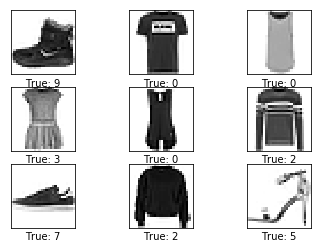

In [19]:
plot_images(X_train, y_train_vec)

================================================================================================

Creating a CNN with the following features:

* 1 input layer with two kernels of size 3 each.
* 1 fully connected layer with 25088 neurons.
* 2 dense layers with 128 and 10 (# of classes) kernels respectively.
* Adam compiler
* Learning Rate = 1e-4
* Batch size = 32
* Epoches = 3

In [22]:
learn_rate = 1e-4

#Initializing the model.
model_2layer = Sequential()

#Adding an input layer.
model_2layer.add(InputLayer(input_shape=(image_row_number, image_col_number, 1, )))

#Adding the first layer.
model_2layer.add(Conv2D(16, kernel_size=3,
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_1'))

#Adding the second layer.
model_2layer.add(Conv2D(32, kernel_size=5,
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_2'))
model_2layer.add(MaxPooling2D(pool_size=(2, 2)))

#Adding one fully connected layer.
model_2layer.add(Flatten())

#Adding one dense layer.
model_2layer.add(Dense(128, activation='relu'))
model_2layer.add(Dense(count_classes, activation='softmax'))

#Compiling the model.
model_2layer.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(lr=learn_rate),
              metrics=['accuracy'])

Viewing a tabular summary of the model:

In [23]:
model_2layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv_1 (Conv2D)        (None, 28, 28, 16)        160       
_________________________________________________________________
layer_conv_2 (Conv2D)        (None, 28, 28, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total para

Training a model on the training set and testing its accuracy on the validation set.

A small batch size is being used, with epochs = 3 to enable the model to traverse the data multiple times for better accuracy.

In [24]:
#Fitting the model on training and testing data.
model_2layer.fit(X_train, y_train,
                  batch_size=32,
                  epochs=3,
                  verbose=1,
                  validation_data=(X_val, y_val))

#Scoring the model on the test data.
score = model_2layer.evaluate(X_test, y_test, verbose=0)

#Printing the score and accuracy:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 1404s 26ms/step - loss: 0.5569 - acc: 0.8069 - val_loss: 0.3888 - val_acc: 0.8592
Epoch 2/3
55000/55000 [==============================] - 1390s 25ms/step - loss: 0.3721 - acc: 0.8699 - val_loss: 0.3342 - val_acc: 0.8784
Epoch 3/3
55000/55000 [==============================] - 1394s 25ms/step - loss: 0.3251 - acc: 0.8857 - val_loss: 0.3019 - val_acc: 0.8878
Test loss: 0.3302122708559036
Test accuracy: 0.8826


As can be seen from the above output, the training accuracy keeps increasing with more epochs, but the validation accuracy reaches a peak and does not increase by much after that. The test set accuracy is similar to the validation set accuracy. The test set now needs to be tested on the model.

Making predictions based on the test set:

In [25]:
y_pred = model_2layer.predict_classes(x=X_test)

Plotting the first 9 images in the test set along with their predictions:

Select the first 9 images


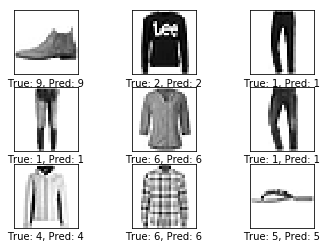

In [26]:
plot_images(X_test, y_test_vec, y_pred)

Creating a function to plot misclassified images:

In [27]:
def plot_example_errors(images, label, pred):
    #Checking for misclassification and creating indexes for such images.
    incorrect = (label != pred)
    
    #Assigning the indexes to the images.
    images = images[incorrect,:,:,:]
    label = label[incorrect]
    pred = pred[incorrect]
    
    #Using the plot_images function to plot the first 9 misclassified images.
    plot_images(images, label, pred)

Plotting a few mismatched images to investigate the shortcomings of the model:

Select the first 9 images


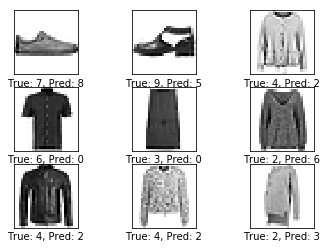

In [28]:
plot_example_errors(X_test, y_test_vec, y_pred)

It can be seen that most mismatches are between shirts, t-shirts and coats, since they look quite similar. This is especially true for given data, since the images are not high resolution, and are also black and white. One possible solution to this is to increase the number of epochs for the model, so that the data can be traversed more times, allowing the model to better distinguish small details between images.

Saving the model:

In [205]:
#Creating variables to store the path and filename of the model.
save_loc = 'C:/Users/Pulkit Dixit/Desktop/STAT 578/HW2/'
model_name = '2layer_model_q3.keras'

#Checking for existence of the path. If the path doesn't exist,
#it will be created.
if not os.path.exists(save_loc):
    os.mkdir(save_loc)

#Saving the model and printing its location.
model_path = os.path.join(save_loc, model_name)
model_2layer.save(model_path)
print('Model saved at location: \n', save_loc)

Model saved at location: 
 C:/Users/Pulkit Dixit/Desktop/STAT 578/HW2/


================================================================================================